In [52]:
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
# converting data into numpy arrays to work with scikit-learn
import numpy as np
import quandl, math
from matplotlib import style

from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression



In [53]:
df = quandl.get('WIKI/GOOGL')
print(df.head())

              Open    High     Low    Close      Volume  Ex-Dividend  \
Date                                                                   
2004-08-19  100.01  104.06   95.96  100.335  44659000.0          0.0   
2004-08-20  101.01  109.08  100.50  108.310  22834300.0          0.0   
2004-08-23  110.76  113.48  109.05  109.400  18256100.0          0.0   
2004-08-24  111.24  111.60  103.57  104.870  15247300.0          0.0   
2004-08-25  104.76  108.00  103.88  106.000   9188600.0          0.0   

            Split Ratio  Adj. Open  Adj. High   Adj. Low  Adj. Close  \
Date                                                                   
2004-08-19          1.0  50.159839  52.191109  48.128568   50.322842   
2004-08-20          1.0  50.661387  54.708881  50.405597   54.322689   
2004-08-23          1.0  55.551482  56.915693  54.693835   54.869377   
2004-08-24          1.0  55.792225  55.972783  51.945350   52.597363   
2004-08-25          1.0  52.542193  54.167209  52.100830   53.1

Since high and low is corrected for in 'adj' high and low, we will create a df with just meaningful columns.

Corrected for in that 'Stock Splits' are accounted for by adjusting; one stock becomes two but the value doesn't change, etc.

In [54]:
df = df[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']]

Let's determine volatility and % change to get a more telling account of how things are going.

In [55]:
df['HL_PCT'] = ((df['Adj. High'] - df['Adj. Low']) / df['Adj. Low'])* 100.0

In [56]:
df['HL_PCT'].head()

Date
2004-08-19    8.441017
2004-08-20    8.537313
2004-08-23    4.062357
2004-08-24    7.753210
2004-08-25    3.966115
Name: HL_PCT, dtype: float64

In [57]:
df['PCT_change'] = ((df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.0)

In [58]:
df['PCT_change'].head()

Date
2004-08-19    0.324968
2004-08-20    7.227007
2004-08-23   -1.227880
2004-08-24   -5.726357
2004-08-25    1.183658
Name: PCT_change, dtype: float64

We are forecasting the price, that is, the price it will close on for the day. That makes 'adj. close' our label.

Features are current price, high minus low percent, and percent change.

In [59]:
forecast_col = 'Adj. Close'
# fill with -99999; treated as outlier.
df.fillna(value=-99999, inplace=True)
# we want to forecast one percent of days
forecast_out = int(math.ceil(0.01 * len(df)))


In [60]:
df['label'] = df[forecast_col].shift(-forecast_out)

In [61]:
df.dropna(inplace=True)

In [62]:
# features
X = np.array(df.drop(['label'],1))
# label
y = np.array(df['label'])

### Preprocessing
Scale X between -1 and 1 for speed/efficiency

In [63]:
X = preprocessing.scale(X)

y = np.array(df['label'])

We use cross_validation to break up the data (shuffled), using part of the data to predict the rest (for example, 75% to predict the remaining 25%).

In [64]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y, test_size=0.2)

Support Vector Regression is a classifier from Scikit-Learn.

In [65]:
clf = svm.SVR()

In [66]:
clf.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [67]:
confidence = clf.score(X_test, y_test)

In [68]:
print(confidence)

0.7921653177796106


Our confidence interval is fairly low. Let's try Linear Regression.

In [69]:
clf2 = LinearRegression()

In [70]:
clf2.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [71]:
confidence2 = clf2.score(X_test, y_test)

In [72]:
print(confidence2)

0.9789253706089016


### N-Jobs to Run Concurrently on Multiple Cores
Check our algorithm's documentation for ability to run on multiple threads

In [73]:
# svr doesn't support threading
# LinearRegression does! Use '-1' for all available
clfnj = LinearRegression(n_jobs = -1)

In [74]:
clfnj.fit(X_train, y_train)
clfnj.score(X_test, y_test)

0.9789253706089016

### Optimizing other Parameters
You can change defaults and should explore them. Here, let's explore the variety of kernals

In [75]:
for n in ['linear', 'poly', 'rbf', 'sigmoid']:
    clf = svm.SVR(kernel=n)
    clf.fit(X_train, y_train)
    confidence = clf.score(X_test, y_test)
    print(n, confidence)

linear 0.9779060498741488
poly 0.6779892339265541
rbf 0.7921653177796106
sigmoid 0.7611582600881457


In [76]:
clfnj = svm.SVR(kernel='linear')
clfnj.fit(X_train, y_train)
confidencef = clfnj.score(X_test, y_test)
print(confidencef)

0.9779060498741488


### Forecasting

In [83]:
df = quandl.get("WIKI/GOOGL")
df = df[['Adj. Open',  'Adj. High',  'Adj. Low',  'Adj. Close', 'Adj. Volume']]
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Low']) / df['Adj. Close'] * 100.0
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.0

df = df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume']]
forecast_col = 'Adj. Close'
df.fillna(value=-99999, inplace=True)
forecast_out = int(math.ceil(0.01 * len(df)))
df['label'] = df[forecast_col].shift(-forecast_out)

X = np.array(df.drop(['label'], 1))
X = preprocessing.scale(X)
X = X[:-forecast_out]
df.dropna(inplace=True)
y = np.array(df['label'])
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)

clf = LinearRegression(n_jobs=-1)
clf.fit(X_train, y_train)
confidence = clf.score(X_test, y_test)
print(confidence)

X = np.array(df.drop(['label'], 1))
X = preprocessing.scale(X)
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

df.dropna(inplace=True)

y = np.array(df['label'])

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)
clf = LinearRegression(n_jobs=-1)
clf.fit(X_train, y_train)
confidence = clf.score(X_test, y_test)
print(confidence)

0.9773776988436454


ValueError: Found input variables with inconsistent numbers of samples: [3354, 3389]

In [84]:
forecast_set = clf.predict(X_lately)

In [85]:
print(forecast_set, confidence, forecast_out)

[1105.92912305 1120.47532934 1134.48390263 1129.33370735 1122.77116386
 1120.58211718 1119.23521708 1115.24413413 1109.32572208 1104.69450637
 1102.85170036 1121.27062267 1140.4081572  1146.40025974 1161.32181491
 1165.8127317  1164.05460872 1161.64933482 1163.46311449 1181.11610116
 1181.05710522 1190.87028121 1187.51506303 1196.03559799 1216.02881339
 1229.99245464 1223.71309969 1236.08000124 1240.78566412 1240.44779625
 1230.94087423 1235.93670227 1234.54468032 1168.14607161 1110.76296554] 0.9773776988436454 35


In [86]:
import datetime
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
df['Forecast'] = np.nan

In [87]:
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

In [88]:
for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += 86400
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]


### Forecast Plot

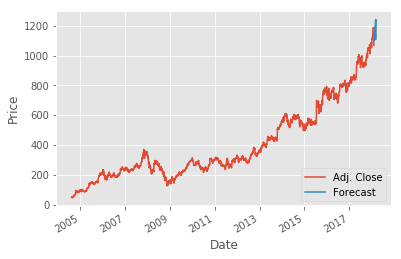

In [89]:
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()
